Simulated Components
- PV with DC/DC and MPPT
- DC/DC charging station for Li-Ion Battery 
- ESS Battery and DC/DC
- Grid Connection to DC/AC Inverter and Transformer



# Fuzzy Logic Excercise
- using skfuzz python toolkit
- pip install scikit-fuzzy

Let’s create a fuzzy control system which models how you might choose to tip at a restaurant. When tipping, you consider the service and food quality, rated between 0 and 10. You use this to leave a tip of between 0 and 25%.

We would formulate this problem as:

- Antecednets (Inputs)
    - service
        - Universe (ie, crisp value range): How good was the service of the wait staff, on a scale of 0 to 10?
        - Fuzzy set (ie, fuzzy value range): poor, acceptable, amazing
    - food quality
        - Universe: How tasty was the food, on a scale of 0 to 10?
        - Fuzzy set: bad, decent, great
- Consequents (Outputs)
    - tip
        - Universe: How much should we tip, on a scale of 0% to 25%
        - Fuzzy set: low, medium, high
- Rules
    - IF the service was good or the food quality was good, THEN the tip will be high.
    - IF the service was average, THEN the tip will be medium.
    - IF the service was poor and the food quality was poor THEN the tip will be low.
- Usage
    - If I tell this controller that I rated:
    - the service as 9.8, and
    - the quality as 6.5,
    - it would recommend I leave: a 20.2% tip.


In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# New Antecedent/Consequent objects hold universe variables and membership
# functions
quality = ctrl.Antecedent(np.arange(0, 11, 1), 'quality')
service = ctrl.Antecedent(np.arange(0, 11, 1), 'service')
tip = ctrl.Consequent(np.arange(0, 26, 1), 'tip')

# Auto-membership function population is possible with .automf(3, 5, or 7)
quality.automf(3)
service.automf(3)

# Custom membership functions can be built interactively with a familiar,
# Pythonic API
tip['low'] = fuzz.trimf(tip.universe, [0, 0, 13])
tip['medium'] = fuzz.trimf(tip.universe, [0, 13, 25])
tip['high'] = fuzz.trimf(tip.universe, [13, 25, 25])

In [ ]:
# You can see how these look with .view()
quality['average'].view()
service.view()
tip.view()

## Fuzzy rules
Now, to make these triangles useful, we define the fuzzy relationship between input and output variables. For the purposes of our example, consider three simple rules:

- If the food is poor OR the service is poor, then the tip will be low
- If the service is average, then the tip will be medium
- If the food is good OR the service is good, then the tip will be high.

Most people would agree on these rules, but the rules are fuzzy. Mapping the imprecise rules into a defined, actionable tip is a challenge. This is the kind of task at which fuzzy logic excels.

In [12]:
rule1 = ctrl.Rule(quality['poor'] | service['poor'], tip['low'])
rule2 = ctrl.Rule(service['average'], tip['medium'])
rule3 = ctrl.Rule(service['good'] | quality['good'], tip['high'])


## Control System Creation and Simulation
Now that we have our rules defined, we can simply create a control system via:

19.847607361963192


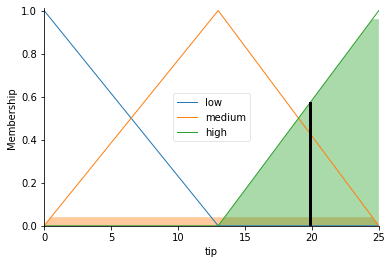

In [10]:
tipping_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
# the simulation can now take different inputs using the controller defined to get different outputs
tipping = ctrl.ControlSystemSimulation(tipping_ctrl)

# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
tipping.input['quality'] = 6.5
tipping.input['service'] = 9.8

# Crunch the numbers
tipping.compute()

print(tipping.output['tip'])
tip.view(sim=tipping)


# Fuzzy Control Systems: Advanced Example

Many fuzzy control systems are tasked to keep a certain variable close to a specific value. For instance, the temperature for an industrial chemical process might need to be kept relatively constant. In order to do this, the system usually knows two things:

    - The error, or deviation from the ideal value
    - The way the error is changing. This is the mathematical first derivative; we’ll call it delta

From these two values we can construct a system which will act appropriately.

In [2]:
import numpy as np
import skfuzzy.control as ctrl

# Sparse universe makes calculations faster, without sacrifice accuracy.
# Only the critical points are included here; making it higher resolution is
# unnecessary.
universe = np.linspace(-2, 2, 5)

# Create the three fuzzy variables - two inputs, one output
error = ctrl.Antecedent(universe, 'error')
delta = ctrl.Antecedent(universe, 'delta')
output = ctrl.Consequent(universe, 'output')

# Here we use the convenience `automf` to populate the fuzzy variables with
# terms. The optional kwarg `names=` lets us specify the names of our Terms.
names = ['nb', 'ns', 'ze', 'ps', 'pb']
error.automf(names=names)
delta.automf(names=names)
output.automf(names=names)



## Define Complex Rules


In [3]:
rule0 = ctrl.Rule(antecedent=((error['nb'] & delta['nb']) |
                              (error['ns'] & delta['nb']) |
                              (error['nb'] & delta['ns'])),
                  consequent=output['nb'], label='rule nb')

rule1 = ctrl.Rule(antecedent=((error['nb'] & delta['ze']) |
                              (error['nb'] & delta['ps']) |
                              (error['ns'] & delta['ns']) |
                              (error['ns'] & delta['ze']) |
                              (error['ze'] & delta['ns']) |
                              (error['ze'] & delta['nb']) |
                              (error['ps'] & delta['nb'])),
                  consequent=output['ns'], label='rule ns')

rule2 = ctrl.Rule(antecedent=((error['nb'] & delta['pb']) |
                              (error['ns'] & delta['ps']) |
                              (error['ze'] & delta['ze']) |
                              (error['ps'] & delta['ns']) |
                              (error['pb'] & delta['nb'])),
                  consequent=output['ze'], label='rule ze')

rule3 = ctrl.Rule(antecedent=((error['ns'] & delta['pb']) |
                              (error['ze'] & delta['pb']) |
                              (error['ze'] & delta['ps']) |
                              (error['ps'] & delta['ps']) |
                              (error['ps'] & delta['ze']) |
                              (error['pb'] & delta['ze']) |
                              (error['pb'] & delta['ns'])),
                  consequent=output['ps'], label='rule ps')

rule4 = ctrl.Rule(antecedent=((error['ps'] & delta['pb']) |
                              (error['pb'] & delta['pb']) |
                              (error['pb'] & delta['ps'])),
                  consequent=output['pb'], label='rule pb')

In [4]:
system = ctrl.ControlSystem(rules=[rule0, rule1, rule2, rule3, rule4])

# Later we intend to run this system with a 21*21 set of inputs, so we allow
# that many plus one unique runs before results are flushed.
# Subsequent runs would return in 1/8 the time!
sim = ctrl.ControlSystemSimulation(system, flush_after_run=21 * 21 + 1)

## View the Control Space

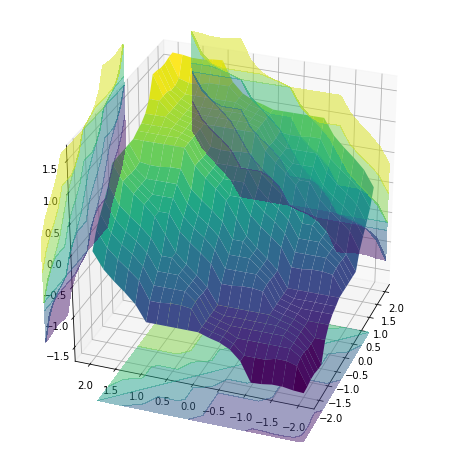

In [5]:
# We can simulate at higher resolution with full accuracy
upsampled = np.linspace(-2, 2, 21)
x, y = np.meshgrid(upsampled, upsampled)
z = np.zeros_like(x)

# Loop through the system 21*21 times to collect the control surface
for i in range(21):
    for j in range(21):
        sim.input['error'] = x[i, j]
        sim.input['delta'] = y[i, j]
        sim.compute()
        z[i, j] = sim.output['output']

# Plot the result in pretty 3D with alpha blending
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

cset = ax.contourf(x, y, z, zdir='z', offset=-2.5, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='y', offset=3, cmap='viridis', alpha=0.5)

ax.view_init(30, 200)